In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/quant_trading/

/content/drive/MyDrive/quant_trading


In [254]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.stats import gaussian_kde
from scipy.stats import kurtosis
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import ks_2samp

**Functions**

In [52]:
# def simulate_markov_returns(n_days, start_price, state_map, bins, method='empirical', jitter=0.1):
#     """
#     Simulates n_days of minute-level returns.

#     Parameters:
#     - n_days: Number of trading days to simulate.
#     - start_price: The price to start the simulation from.
#     - state_map: Dictionary mapping state index to list of next-minute returns.
#     - bins: The return boundaries used to define states.
#     - method: 'empirical' (random choice + noise) or 'kde' (smooth sampling).
#     - jitter: Scale of noise for empirical method (fraction of bin std dev).
#     """
#     current_price = start_price
#     prices = [current_price]

#     # Pre-fit KDEs if using KDE method to save time
#     kdes = {}
#     if method == 'kde':
#         for state, returns in state_map.items():
#             if len(returns) > 1: # KDE needs at least 2 points
#                 kdes[state] = gaussian_kde(returns)

#     # Initialize with a random return from the data to get the first state
#     current_ret = np.random.choice(np.concatenate(list(state_map.values())))

#     for day in range(n_days):
#         for minute in range(390):
#             # 1. Determine current state based on previous return
#             state = np.digitize(current_ret, bins) - 1
#             state = max(0, min(state, len(bins) - 2)) # Boundary safety

#             # 2. Sample next return based on chosen method
#             if method == 'empirical':
#                 choices = state_map[state]
#                 sampled_return = np.random.choice(choices)
#                 # Add noise: N(0, std * jitter)
#                 noise = np.random.normal(0, np.std(choices) * jitter)
#                 current_ret = sampled_return + noise

#             elif method == 'kde':
#                 if state in kdes:
#                     current_ret = kdes[state].resample(1)[0][0]
#                 else:
#                     # Fallback to empirical if KDE fails for a sparse bin
#                     current_ret = np.random.choice(state_map[state])

#             # 3. Update price
#             current_price *= (1 + current_ret)
#             prices.append(current_price)

#         # Optional: Apply an overnight gap here if desired

#     return np.array(prices)

In [258]:
# def simulate_markov_returns_fast(n_days, start_price, state_map, bins, method='empirical', jitter=0.0,threshold = 1e-9):
#     total_minutes = n_days * 390

#     # PRE-CALCULATION: Convert lists to arrays and pre-compute std devs
#     # This removes the heavy lifting from the inner loop
#     processed_map = {}
#     for state, rets in state_map.items():
#         arr = np.array(rets)
#         processed_map[state] = {
#             'choices': arr,
#             'std': np.std(arr) if len(arr) > 1 else 0
#         }

#     # Initialize
#     all_returns = np.zeros(total_minutes)
#     current_ret = np.random.choice(np.concatenate(list(state_map.values())))

#     # The Loop: Still necessary for Markov dependency, but much lighter
#     for i in range(total_minutes):
#         # 1. Faster State Lookup
#         state = np.digitize(current_ret, bins) - 1
#         state = max(0, min(state, len(bins) - 2))

#         state_data = processed_map[state]

#         # 2. Optimized Sampling
#         choices = state_data['choices']
#         # Pulling one random index is faster than np.random.choice on the whole array
#         sampled_return = choices[np.random.randint(len(choices))]

#         if abs(sampled_return) < threshold:
#           current_ret = 0.0  # Lock it to zero
#         else:
#           noise = np.random.normal(0, state_data['std'] * jitter)
#           current_ret = sampled_return + noise

#         all_returns[i] = current_ret

#     # 3. VECTORIZED PRICE CALCULATION
#     # (1 + r1) * (1 + r2) ... is done in one shot by NumPy in C-code
#     price_path = start_price * np.cumprod(1 + all_returns)

#     # Prepend start_price to match your original output format
#     return np.insert(price_path, 0, start_price)

In [13]:
def get_transition_matrix(df):
    # Create local copy to avoid SettingWithCopy warnings
    df_temp = df.copy()

    # Define states (10 deciles) based on the returns in this specific era
    df_temp['state'] = pd.qcut(df_temp['return'], 10, labels=False)

    # We shift within the 'date' group to avoid overnight transitions
    df_temp['next_state'] = df_temp.groupby('date')['state'].shift(-1)

    # Create the probability matrix (normalized by row)
    matrix = pd.crosstab(df_temp['state'], df_temp['next_state'], normalize='index')
    return matrix

In [259]:
def build_state_map_with_zeros(recent_data, threshold=1e-9):
    # Ensure next_return exists
    recent_data['next_return'] = recent_data.groupby('date')['return'].shift(-1)

    # 1. APPLY THRESHOLD: Force tiny floating point values to absolute zero
    recent_data.loc[recent_data['next_return'].abs() < threshold, 'next_return'] = 0.0

    # 2. Group by state and map
    state_map = (recent_data.dropna(subset=['next_return', 'state'])
                 .groupby('state')['next_return']
                 .apply(list).to_dict())

    return state_map

In [309]:
def simulate_markov_hybrid(n_days, start_price, state_map, bins,
                           jitter=0.001, tail_threshold=0.05, zero_threshold=1e-9):
    total_minutes = n_days * 390
    num_bins = len(bins) - 1

    # 1. PRE-CALCULATION: Pre-sample buckets for speed
    # We identify tails as the outer percentiles defined by tail_threshold
    tail_count = int(num_bins * tail_threshold)
    tail_indices = list(range(tail_count)) + list(range(num_bins - tail_count, num_bins))

    pre_sampled_buckets = {}
    state_stds = {}

    for state, rets in state_map.items():
        arr = np.array(rets)
        state_stds[state] = np.std(arr)

        # Use KDE for middle states to smooth the distribution for the KS Test
        if state not in tail_indices and len(arr) > 50:
            kde = gaussian_kde(arr)
            # 10k samples per state ensures enough variety for 500 paths
            pre_sampled_buckets[state] = kde.resample(10000).flatten()
        else:
            # Keep empirical data for tails to preserve Kurtosis
            pre_sampled_buckets[state] = arr

    all_returns = np.zeros(total_minutes)
    current_ret = 0.0

    # 2. THE SIMULATION LOOP
    for i in range(total_minutes):
        state = np.digitize(current_ret, bins) - 1
        state = max(0, min(state, len(bins) - 2))

        choices = pre_sampled_buckets[state]
        sampled = choices[np.random.randint(len(choices))]

        # Apply Zero-Lock Logic
        if abs(sampled) < zero_threshold:
            current_ret = 0.0
        else:
            # Apply Jitter only to Empirical Tail states
            if state in tail_indices:
                noise = np.random.normal(0, state_stds[state] * jitter)
                current_ret = sampled + noise
            else:
                current_ret = sampled

        all_returns[i] = current_ret

    price_path = start_price * np.cumprod(1 + all_returns)
    return np.insert(price_path, 0, start_price)

In [219]:
def check_volatility_clustering(real_rets, sim_df, lags=30):
    # Absolute returns highlight the 'magnitude' of the move
    real_abs = np.abs(real_rets)
    # Average absolute returns across all paths for a global model check
    sim_abs = np.abs(sim_df.pct_change().dropna()).mean(axis=1)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(real_abs, lags=lags, ax=ax[0], title="Real Volatility Clustering")
    plot_acf(sim_abs, lags=lags, ax=ax[1], title="Simulated Volatility Clustering")
    plt.show()

In [220]:
def calculate_hurst(price_path):
    """Calculates the Hurst Exponent to check for long-term memory."""
    lags = range(2, 100)
    # Calculate the variance of the difference between price points at different lags
    tau = [np.sqrt(np.std(np.subtract(price_path[lag:], price_path[:-lag]))) for lag in lags]

    # Use a linear fit to find the power-law relationship
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

In [221]:
def get_max_drawdown(path):
    rolling_max = np.maximum.accumulate(path)
    drawdowns = (path - rolling_max) / rolling_max
    return np.min(drawdowns)

In [230]:
def test_leverage_effect(returns):
    """Checks if negative returns lead to higher subsequent volatility."""
    abs_returns = np.abs(returns[1:])
    lagged_returns = returns[:-1]
    correlation = np.corrcoef(lagged_returns, abs_returns)[0, 1]
    return correlation

In [231]:
def volatility_persistence(returns, threshold_quantile=0.95):
    """Measures how long high-volatility events tend to last."""
    threshold = np.quantile(np.abs(returns), threshold_quantile)
    is_volatile = np.abs(returns) > threshold

    # Count consecutive True values (persistence)
    persistence = []
    count = 0
    for v in is_volatile:
        if v: count += 1
        else:
            if count > 0: persistence.append(count)
            count = 0
    return np.mean(persistence) if persistence else 0

In [274]:
def check_zero_frequency(returns, label, threshold = 1e-9):
    # Defining 'zero' as moves smaller than 1e-7 to account for float precision
    zeros = np.sum(np.abs(returns) < threshold)
    total = len(returns)
    freq = (zeros / total) * 100
    print(f"{label} Zero-Return Frequency: {freq:.2f}%")
    return freq

**Start**

In [36]:
data = pd.read_parquet('Intraday_Clean_Data/VOO_clean_intraday_2010_2024.parquet')

In [37]:
era_early = data[data.index.year.isin([2011, 2012, 2013])]
era_recent = data[data.index.year.isin([2022, 2023, 2024])]

# 2. Calculate the matrices
mat_early = get_transition_matrix(era_early)
mat_recent = get_transition_matrix(era_recent)

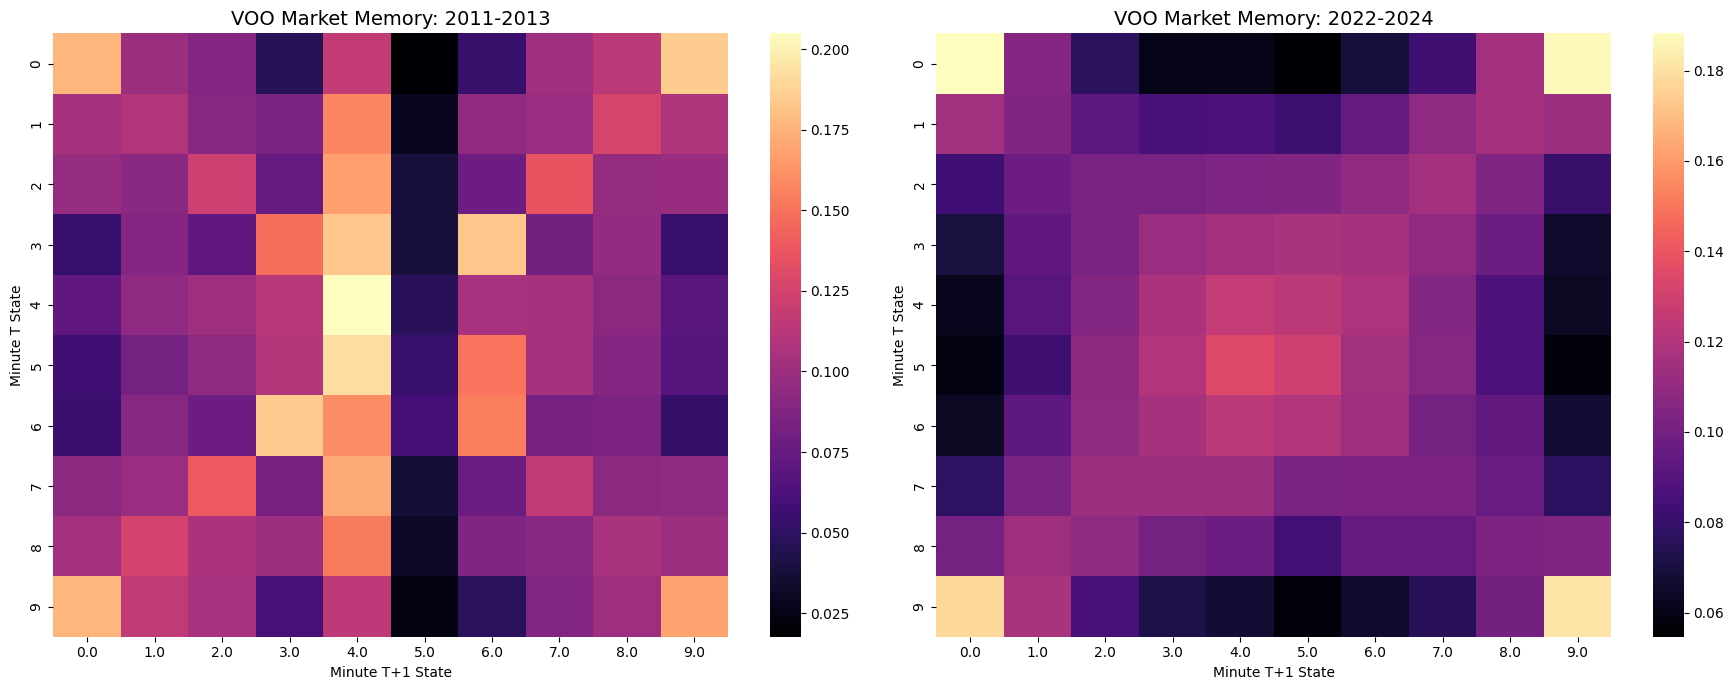

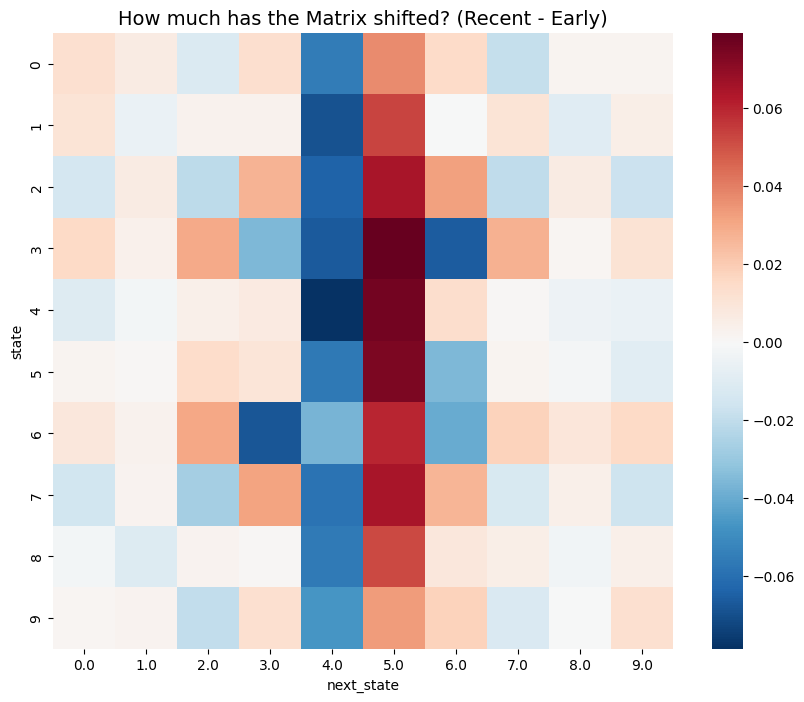

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(mat_early, annot=False, cmap='magma', ax=ax[0])
ax[0].set_title('VOO Market Memory: 2011-2013', fontsize=14)
ax[0].set_xlabel('Minute T+1 State')
ax[0].set_ylabel('Minute T State')

sns.heatmap(mat_recent, annot=False, cmap='magma', ax=ax[1])
ax[1].set_title('VOO Market Memory: 2022-2024', fontsize=14)
ax[1].set_xlabel('Minute T+1 State')
ax[1].set_ylabel('Minute T State')

plt.tight_layout()
plt.show()

# 4. Calculate the "Drift" (Difference)
diff_matrix = mat_recent - mat_early
plt.figure(figsize=(10, 8))
sns.heatmap(diff_matrix, center=0, cmap='RdBu_r', annot=False)
plt.title('How much has the Matrix shifted? (Recent - Early)', fontsize=14)
plt.show()

**Simulation**


In [103]:
# # 1. Setup Parameters from your 'data'
# # Use the most recent 3 years for the "current" transition matrix
# number_of_bins = 30
# recent_data = data[data.index.year.isin([2020 ,2021, 2022, 2023])].copy()
# recent_data['state'], current_bins = pd.qcut(recent_data['return'], number_of_bins, labels=False, retbins=True)
# recent_data['next_return'] = recent_data.groupby('date')['return'].shift(-1)
# current_state_map = recent_data.dropna(subset=['next_return']).groupby('state')['next_return'].apply(list).to_dict()

In [337]:
# 1. Setup Parameters
# Keeping 2018-2023 to provide "fuel" for the extreme bins
recent_data = data[data.index.year.isin([2018, 2019, 2020, 2021, 2022, 2023])].copy()
threshold_for_zero = 1e-5

# 2. DEFINE EXTREME TAIL-HEAVY PERCENTILES
# Added 0.0001 (0.01%) and 0.9999 (99.99%) to isolate the highest-impact outliers
custom_quantiles = [0, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
                    0.4, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999, 1.0]

# Generate numeric bin edges from these quantiles
current_bins = np.unique(recent_data['return'].quantile(custom_quantiles).values)

# 3. APPLY CUSTOM BINS
recent_data['state'] = pd.cut(recent_data['return'], bins=current_bins, labels=False, include_lowest=True)

# 4. Map States to Next Returns
recent_data['next_return'] = recent_data.groupby('date')['return'].shift(-1)

current_state_map = build_state_map_with_zeros(recent_data,threshold=threshold_for_zero)

In [353]:
# Identify the start price: The very last closing price of 2023
month_shifted = 3
shift_by = 390*21*month_shifted
if shift_by == 0:
  starting_price_2024 = data[data.index.year == 2023]['Close'].iloc[-1]
else:
  starting_price_2024 = data[data.index.year == 2024]['Close'].iloc[shift_by-1]

sim_results = []
n_simulations = 100  # Increase later for better stats

for i in range(n_simulations):
    print(f"Simulation Number: {i}...")
    path = simulate_markov_hybrid(
        n_days=21, # Approx trading days in a month
        start_price=starting_price_2024,
        state_map=current_state_map,
        bins=current_bins,
        jitter=0.001,    # Adding 10% noise to the historical samples
        tail_threshold= 0.05,
        zero_threshold= threshold_for_zero
    )
    sim_results.append(path)

# Convert to DataFrame: Rows = Minutes, Columns = Simulation Path
sim_df = pd.DataFrame(sim_results).T

Simulation Number: 0...
Simulation Number: 1...
Simulation Number: 2...
Simulation Number: 3...
Simulation Number: 4...
Simulation Number: 5...
Simulation Number: 6...
Simulation Number: 7...
Simulation Number: 8...
Simulation Number: 9...
Simulation Number: 10...
Simulation Number: 11...
Simulation Number: 12...
Simulation Number: 13...
Simulation Number: 14...
Simulation Number: 15...
Simulation Number: 16...
Simulation Number: 17...
Simulation Number: 18...
Simulation Number: 19...
Simulation Number: 20...
Simulation Number: 21...
Simulation Number: 22...
Simulation Number: 23...
Simulation Number: 24...
Simulation Number: 25...
Simulation Number: 26...
Simulation Number: 27...
Simulation Number: 28...
Simulation Number: 29...
Simulation Number: 30...
Simulation Number: 31...
Simulation Number: 32...
Simulation Number: 33...
Simulation Number: 34...
Simulation Number: 35...
Simulation Number: 36...
Simulation Number: 37...
Simulation Number: 38...
Simulation Number: 39...
Simulation

**Fan Chart**

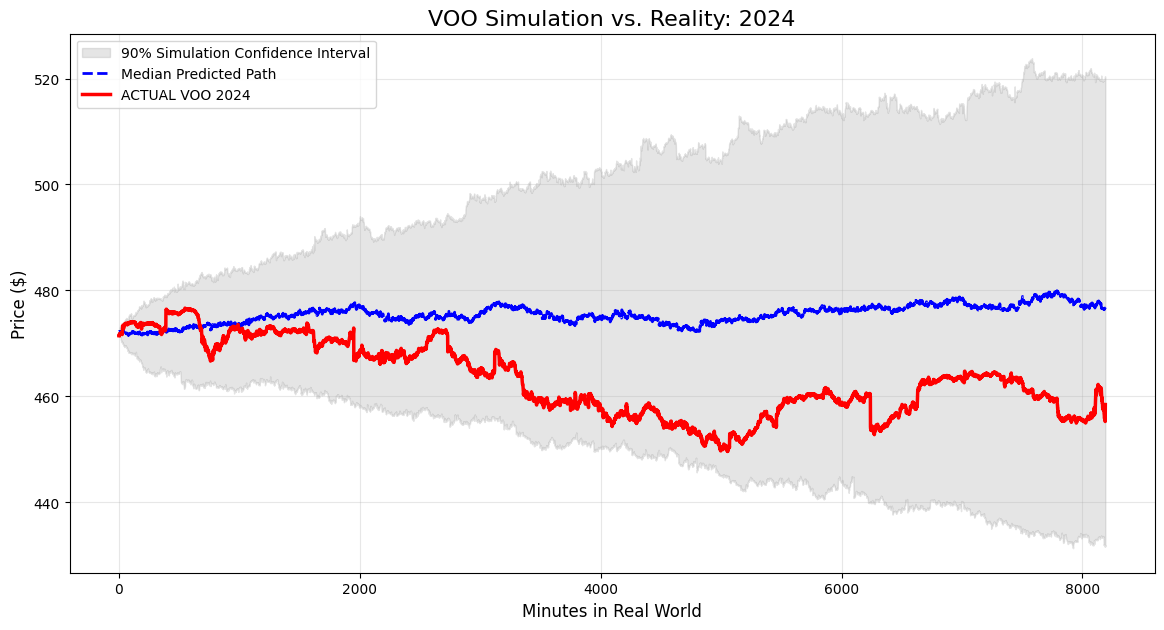

In [354]:
# 1. Extract Real 2024 Price Path
# We filter the 'data' variable for the actual realization of Jan 2024
real_2024 = data[data.index.year == 2024].copy()
real_prices = real_2024['Close'].values

# 2. Calculate Simulation Percentiles (from your sim_df)
sim_median = sim_df.median(axis=1)
sim_upper_95 = sim_df.quantile(0.95, axis=1)
sim_lower_05 = sim_df.quantile(0.05, axis=1)

# 3. Enhanced Fan Chart with Real Data
plt.figure(figsize=(14, 7))

# Plot the 'Probability Cloud'
plt.fill_between(range(len(sim_median)), sim_lower_05, sim_upper_95,
                 color='gray', alpha=0.2, label='90% Simulation Confidence Interval')

# Plot the Median Simulated Path
plt.plot(sim_median, color='blue', lw=2, label='Median Predicted Path', linestyle='--')

# Plot the ACTUAL 2024 Market Path
# Note: We ensure the lengths match or slice to the shorter of the two
plt.plot(real_prices[shift_by:shift_by+len(sim_median)], color='red', lw=2.5, label='ACTUAL VOO 2024')

plt.title("VOO Simulation vs. Reality: 2024", fontsize=16)
plt.xlabel("Minutes in Real World", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

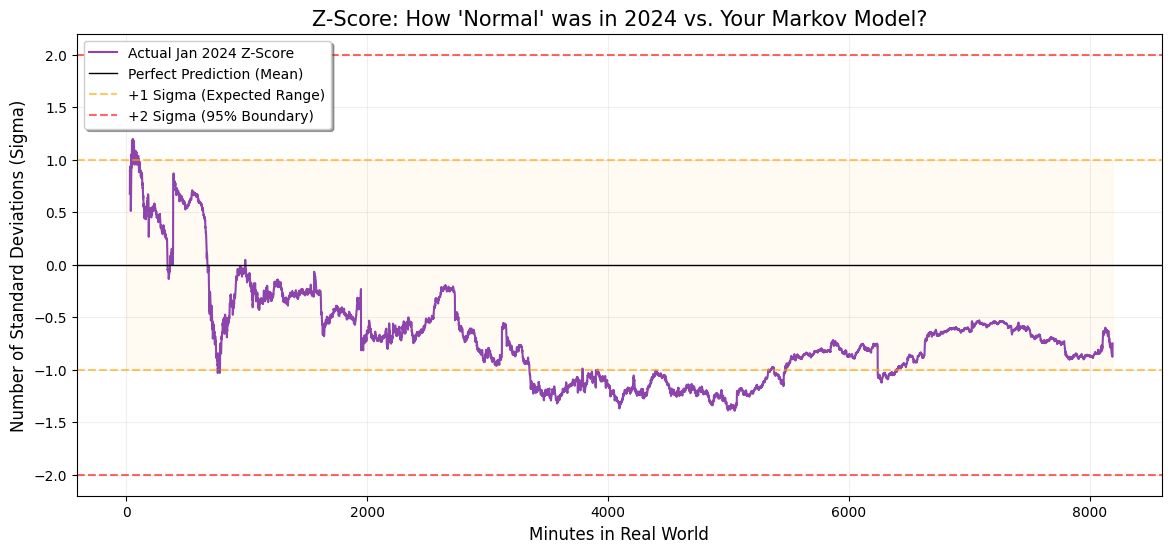

Final Z-Score for 2024: -0.75


In [355]:
# 1. Calculate Z-Score
# Mean and Std of your 10 simulations
sim_means = sim_df.mean(axis=1)
sim_stds = sim_df.std(axis=1)

# Ensure the actual prices match the length of the simulation
actual_path = real_prices[shift_by:shift_by+len(sim_means)]

# Formula: (Actual - Predicted Mean) / Predicted StdDev
z_scores = (actual_path - sim_means) / sim_stds

# 2. Apply Stability Mask
# We ignore the first 30 minutes where standard deviation is near-zero
stability_mask = 30
z_scores_stable = z_scores.copy()
z_scores_stable.iloc[:stability_mask] = np.nan

# 3. Create the Plot
plt.figure(figsize=(14, 6))

# Plot the Z-score line
plt.plot(z_scores_stable.index, z_scores_stable, color='#8e44ad', lw=1.5, label='Actual Jan 2024 Z-Score')

# Add Horizontal Reference Lines
plt.axhline(0, color='black', lw=1, label='Perfect Prediction (Mean)')
plt.axhline(1, color='orange', linestyle='--', alpha=0.6, label='+1 Sigma (Expected Range)')
plt.axhline(-1, color='orange', linestyle='--', alpha=0.6)
plt.axhline(2, color='red', linestyle='--', alpha=0.6, label='+2 Sigma (95% Boundary)')
plt.axhline(-2, color='red', linestyle='--', alpha=0.6)

# Fill the "Typical" zone
plt.fill_between(z_scores_stable.index, -1, 1, color='orange', alpha=0.05)

# Labels and Styling
plt.title("Z-Score: How 'Normal' was in 2024 vs. Your Markov Model?", fontsize=15)
plt.xlabel("Minutes in Real World", fontsize=12)
plt.ylabel("Number of Standard Deviations (Sigma)", fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(alpha=0.2)

plt.show()

# 4. Final Prediction Grade
final_z = z_scores_stable.iloc[-1]
print(f"Final Z-Score for 2024: {final_z:.2f}")

**Statistical Test**

In [356]:
# 1. Align the data
aligned_real = real_prices[shift_by:shift_by+len(sim_median)]

# 2. Compare Volatility (Standard Deviation of returns)
real_vol = np.std(np.diff(np.log(aligned_real)))
sim_vol = np.std(np.diff(np.log(sim_df.iloc[:, 0]))) # Check the first simulation

print(f"Real 2024 Volatility: {real_vol:.6f}")
print(f"Simulated Volatility: {sim_vol:.6f}")

# 3. Compare the 'Fatness' of the tails (Kurtosis)
real_kurt = kurtosis(np.diff(np.log(aligned_real)))

all_sim_returns = np.diff(np.log(sim_df.values), axis=0).flatten()
sim_kurt = kurtosis(all_sim_returns) # All sims combined

print(f"Real 2024 Kurtosis: {real_kurt:.2f}")
print(f"Simulated Kurtosis: {sim_kurt:.2f}")

Real 2024 Volatility: 0.000472
Simulated Volatility: 0.000558
Real 2024 Kurtosis: 160.06
Simulated Kurtosis: 47.50


In [357]:
real_returns = pd.Series(np.diff(np.log(aligned_real)))

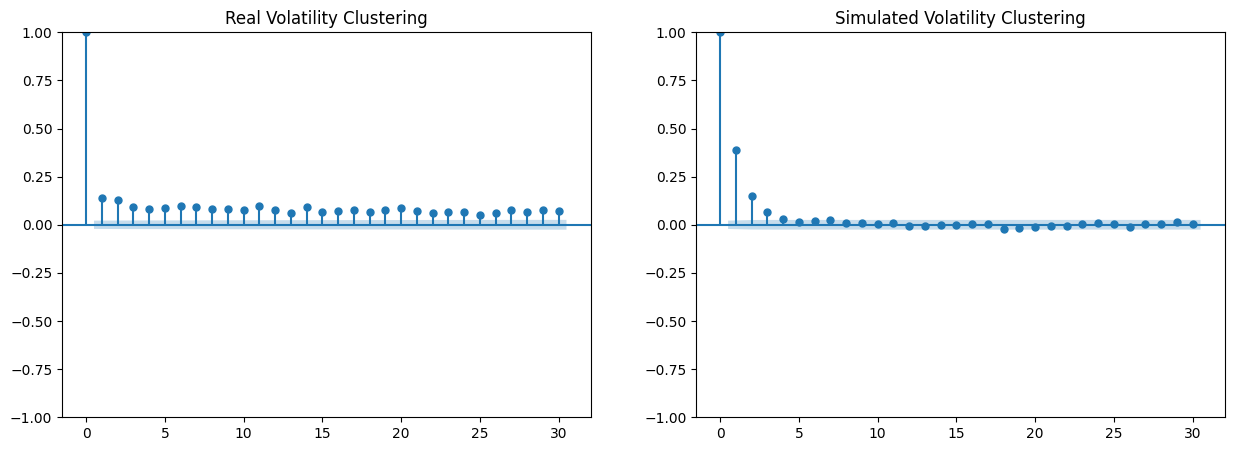

In [358]:
check_volatility_clustering(real_returns, sim_df, lags=30)

In [359]:
real_h = calculate_hurst(aligned_real)
sim_h_values = [calculate_hurst(sim_df[col].values) for col in sim_df.columns]

print(f"Real Hurst: {real_h:.3f}")
print(f"Simulated Hurst (Avg): {np.mean(sim_h_values):.3f}")

Real Hurst: 0.499
Simulated Hurst (Avg): 0.498


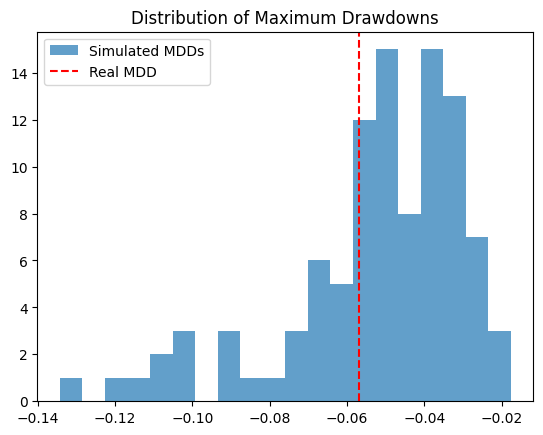

In [360]:
real_mdd = get_max_drawdown(aligned_real)
sim_mdds = [get_max_drawdown(sim_df[col].values) for col in sim_df.columns]

plt.hist(sim_mdds, bins=20, alpha=0.7, label='Simulated MDDs')
plt.axvline(real_mdd, color='red', linestyle='dashed', label='Real MDD')
plt.title("Distribution of Maximum Drawdowns")
plt.legend()
plt.show()

In [361]:
real_leverage = test_leverage_effect(real_returns)
sim_leverage = np.mean([test_leverage_effect(sim_df[col].pct_change().dropna().values) for col in sim_df.columns])

print(f"Real Leverage Correlation: {real_leverage:.3f}")
print(f"Simulated Leverage Correlation: {sim_leverage:.3f}")

Real Leverage Correlation: -0.032
Simulated Leverage Correlation: -0.001


In [362]:
real_persist = volatility_persistence(real_returns)
sim_persist = np.mean([volatility_persistence(sim_df[col].pct_change().dropna().values) for col in sim_df.columns])

print(f"Real Volatility Persistence (Avg Minutes): {real_persist:.2f}")
print(f"Simulated Volatility Persistence (Avg Minutes): {sim_persist:.2f}")

Real Volatility Persistence (Avg Minutes): 1.23
Simulated Volatility Persistence (Avg Minutes): 1.33


In [363]:
# Use the flattened returns from all 500 simulations
all_sim_returns = sim_df.pct_change().dropna().values.flatten()
real_returns = pd.Series(np.diff(np.log(aligned_real)))

ks_stat, p_value = ks_2samp(real_returns, all_sim_returns)

print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value > 0.05:
    print("Result: Your simulation matches the real distribution (Success!)")
else:
    print("Result: Significant difference detected (Check tail bins or jitter)")

KS Statistic: 0.0193
P-Value: 0.0046
Result: Significant difference detected (Check tail bins or jitter)


In [364]:
real_zero = check_zero_frequency(real_returns.values, "Real 2024",threshold= threshold_for_zero)
sim_zero = check_zero_frequency(all_sim_returns, "Simulated (500 paths)",threshold=threshold_for_zero)

Real 2024 Zero-Return Frequency: 2.45%
Simulated (500 paths) Zero-Return Frequency: 3.21%
